In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import warnings 
warnings.filterwarnings('ignore')

In [3]:
train_data=pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test_data=pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
df_sample_submission=pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')

In [4]:
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Sample Submission shape:", df_sample_submission.shape)

Train shape: (188533, 13)
Test shape: (125690, 12)
Sample Submission shape: (125690, 2)


In [5]:
train_data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [6]:
test_data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


# Exploratory Data Analysis

In [7]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB
None


In [8]:
print(train_data.isnull().sum())

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64


In [9]:
print(f'Missing values: {train_data.isna().sum().sum()}')
print(f'Duplicated values: {train_data.duplicated().sum()}')

Missing values: 28954
Duplicated values: 0


In [10]:
print(test_data.isnull().sum())

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64


In [11]:
print(f'Missing values: {test_data.isna().sum().sum()}')
print(f'Duplicated values: {test_data.duplicated().sum()}')

Missing values: 19254
Duplicated values: 0


In [12]:
train_data['fuel_type'].fillna('Electricity', inplace=True)
train_data['clean_title'].fillna('No', inplace=True)
train_data['accident'].fillna('None reported', inplace=True)

test_data['fuel_type'].fillna('Electricity', inplace=True)
test_data['clean_title'].fillna('No', inplace=True)
test_data['accident'].fillna('None reported', inplace=True)

In [13]:
print(f'Missing values in train_data: {train_data.isna().sum().sum()}')
print(f'Missing values in test_data {test_data.isna().sum().sum()}')

Missing values in train_data: 0
Missing values in test_data 0


In [14]:
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
print(num_cols)

Index(['id', 'model_year', 'milage', 'price'], dtype='object')


In [15]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,188533.0,94266.000000,54424.933488,0.0,47133.0,94266.0,141399.0,188532.0
model_year,188533.0,2015.829998,5.660967,1974.0,2013.0,2017.0,2020.0,2024.0
milage,188533.0,65705.295174,49798.158076,100.0,24115.0,57785.0,95400.0,405000.0
price,188533.0,43878.016178,78819.522254,2000.0,17000.0,30825.0,49900.0,2954083.0


In [16]:
cat_cols = train_data.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title'],
      dtype='object')


In [17]:
train_data[cat_cols].nunique()

brand             57
model           1897
fuel_type          8
engine          1117
transmission      52
ext_col          319
int_col          156
accident           2
clean_title        2
dtype: int64

### Key Observations:
1. **`brand`**: 57 unique car brands.
2. **`model`**: 1897 unique car models, which means that the model is a high-cardinality feature.
3. **`fuel_type`**: 8 unique fuel types, which is a manageable number of categories for one-hot encoding.
4. **`engine`**: 1117 unique engine descriptions, which also makes it a high-cardinality feature.
5. **`transmission`**: 52 unique transmission types.
6. **`ext_col` (exterior color)**: 319 unique colors, which is moderately high.
7. **`int_col` (interior color)**: 156 unique colors.
8. **`accident`**: Binary variable with two categories.
9. **`clean_title`**: Binary variable with two categories.

# Feature Engineering

In [18]:
train_data.drop(columns=['id'], inplace=True)
test_data.drop(columns=['id'], inplace=True)

In [19]:
# Create the new 'car_age' feature based on the model year
current_year = 2024
train_data['car_age'] = current_year - train_data['model_year']
test_data['car_age'] = current_year - test_data['model_year']


In [20]:
train_data['engine'].unique()

array(['172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel',
       '252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel',
       '320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability', ...,
       '78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel',
       '139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas',
       '313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas'],
      dtype=object)

In [21]:
# Function to extract horsepower from engine column
def extract_horsepower(engine_str):
    match = re.search(r'(\d+)\.?\d*HP', engine_str)
    return int(match.group(1)) if match else None

# Function to extract engine size from engine column
def extract_engine_size(engine_str):
    match = re.search(r'(\d+\.?\d*)L', engine_str)
    return float(match.group(1)) if match else None

# Function to extract cylinder count from engine column
def extract_cylinder_count(engine_str):
    match = re.search(r'(\d+) Cylinder', engine_str)
    return int(match.group(1)) if match else None

In [22]:
# Apply the extraction functions to both training and test datasets
train_data['horsepower'] = train_data['engine'].apply(extract_horsepower)
train_data['engine_size'] = train_data['engine'].apply(extract_engine_size)

test_data['horsepower'] = test_data['engine'].apply(extract_horsepower)
test_data['engine_size'] = test_data['engine'].apply(extract_engine_size)

# Apply the extraction function to both training and test datasets
train_data['cylinder_count'] = train_data['engine'].apply(extract_cylinder_count)
test_data['cylinder_count'] = test_data['engine'].apply(extract_cylinder_count)

In [23]:
# Drop the original 'engine' column
train_data.drop('engine', axis=1, inplace=True)
test_data.drop('engine', axis=1, inplace=True)

In [24]:
# Inspect the new features in the training data
train_data[['horsepower', 'engine_size', 'cylinder_count', 'car_age']].head()

,horsepower,engine_size,cylinder_count,car_age
0,172.0,1.6,4.0,17
1,252.0,3.9,8.0,22
2,320.0,5.3,8.0,22
3,420.0,5.0,8.0,7
4,208.0,2.0,4.0,3


In [25]:
train_data['fuel_type'].unique()

array(['Gasoline', 'E85 Flex Fuel', 'Electricity', 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [26]:
# Replace unsupported values in 'fuel_type'
train_data['fuel_type'].replace(['–', 'not supported'], 'Unknown', inplace=True)
test_data['fuel_type'].replace(['–', 'not supported'], 'Unknown', inplace=True)

In [27]:
# Check the unique values again
print(train_data['fuel_type'].unique())
print(test_data['fuel_type'].unique())

['Gasoline' 'E85 Flex Fuel' 'Electricity' 'Hybrid' 'Diesel'
 'Plug-In Hybrid' 'Unknown']
['Gasoline' 'Hybrid' 'Diesel' 'E85 Flex Fuel' 'Electricity'
 'Plug-In Hybrid' 'Unknown']


In [28]:
train_data['transmission'].unique()

array(['A/T', 'Transmission w/Dual Shift Mode', '7-Speed A/T',
       '8-Speed A/T', '10-Speed Automatic', '1-Speed A/T', '6-Speed A/T',
       '10-Speed A/T', '9-Speed A/T', '8-Speed Automatic',
       '9-Speed Automatic', '5-Speed A/T', 'Automatic',
       '7-Speed Automatic with Auto-Shift', 'CVT Transmission',
       '5-Speed M/T', 'M/T', '6-Speed M/T', '6-Speed Automatic',
       '4-Speed Automatic', '7-Speed M/T', '2-Speed A/T',
       '1-Speed Automatic', 'Automatic CVT', '4-Speed A/T',
       '6-Speed Manual', 'Transmission Overdrive Switch',
       '8-Speed Automatic with Auto-Shift', '7-Speed Manual',
       '7-Speed Automatic', '9-Speed Automatic with Auto-Shift',
       '6-Speed Automatic with Auto-Shift',
       '6-Speed Electronically Controlled Automatic with O', 'F', 'CVT-F',
       '8-Speed Manual', 'Manual', '–', '2', '6 Speed At/Mt',
       '5-Speed Automatic', '2-Speed Automatic', '8-SPEED A/T', '7-Speed',
       'Variable', 'Single-Speed Fixed Gear', '8-SPEED AT',


In [29]:
# Implementing the extraction of 'Transmission Type' and 'Number of Speeds' for both training and test datasets
def extract_transmission_type(transmission_str):
    if 'Automatic' in transmission_str or 'A/T' in transmission_str:
        return 'Automatic'
    elif 'Manual' in transmission_str or 'M/T' in transmission_str:
        return 'Manual'
    elif 'CVT' in transmission_str:
        return 'CVT'
    else:
        return 'Other'

def extract_speeds(transmission_str):
    match = re.search(r'(\d+)-Speed', transmission_str)
    return int(match.group(1)) if match else None



In [30]:
# Apply the extraction functions to both the training and test datasets
train_data['transmission_type'] = train_data['transmission'].apply(extract_transmission_type)
train_data['num_speeds'] = train_data['transmission'].apply(extract_speeds)

test_data['transmission_type'] = test_data['transmission'].apply(extract_transmission_type)
test_data['num_speeds'] = test_data['transmission'].apply(extract_speeds)


In [31]:
# Drop the original 'transmission' column
train_data.drop('transmission', axis=1, inplace=True)
test_data.drop('transmission', axis=1, inplace=True)

In [32]:
# Inspect the new features in the training data
train_data[['transmission_type', 'num_speeds']].head()

,transmission_type,num_speeds
0,Automatic,NaN
1,Automatic,NaN
2,Automatic,NaN
3,Other,NaN
4,Automatic,7.0


In [33]:
train_data['transmission_type'].unique()

array(['Automatic', 'Other', 'CVT', 'Manual'], dtype=object)

In [34]:
train_data['num_speeds'].unique()

array([nan,  7.,  8., 10.,  1.,  6.,  9.,  5.,  4.,  2.])

In [35]:
print(train_data.isnull().sum())

brand                    0
model                    0
model_year               0
milage                   0
fuel_type                0
ext_col                  0
int_col                  0
accident                 0
clean_title              0
price                    0
car_age                  0
horsepower           33259
engine_size          14214
cylinder_count       37855
transmission_type        0
num_speeds           84454
dtype: int64


In [36]:
# Initialize SimpleImputer with strategy='mean' for filling missing values
imputer = SimpleImputer(strategy='mean')

# Selecting the numerical columns that have missing values
numerical_cols_to_impute = ['horsepower', 'engine_size', 'cylinder_count', 'num_speeds']

# Apply the imputer to the selected numerical columns in both train and test datasets
train_data[numerical_cols_to_impute] = imputer.fit_transform(train_data[numerical_cols_to_impute])
test_data[numerical_cols_to_impute] = imputer.transform(test_data[numerical_cols_to_impute])

In [37]:
# Check if missing values have been filled in the training data
missing_values_after_simple_imputation = train_data[numerical_cols_to_impute].isnull().sum()

# Check if missing values have been filled in the test data
missing_values_test_after_simple_imputation = test_data[numerical_cols_to_impute].isnull().sum()

missing_values_after_simple_imputation, missing_values_test_after_simple_imputation

(horsepower        0
 engine_size       0
 cylinder_count    0
 num_speeds        0
 dtype: int64,
 horsepower        0
 engine_size       0
 cylinder_count    0
 num_speeds        0
 dtype: int64)

In [38]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   brand              188533 non-null  object 
 1   model              188533 non-null  object 
 2   model_year         188533 non-null  int64  
 3   milage             188533 non-null  int64  
 4   fuel_type          188533 non-null  object 
 5   ext_col            188533 non-null  object 
 6   int_col            188533 non-null  object 
 7   accident           188533 non-null  object 
 8   clean_title        188533 non-null  object 
 9   price              188533 non-null  int64  
 10  car_age            188533 non-null  int64  
 11  horsepower         188533 non-null  float64
 12  engine_size        188533 non-null  float64
 13  cylinder_count     188533 non-null  float64
 14  transmission_type  188533 non-null  object 
 15  num_speeds         188533 non-null  float64
dtypes:

In [39]:
cat_cols = train_data.select_dtypes(include=['object']).columns
train_data[cat_cols].nunique()

brand                  57
model                1897
fuel_type               7
ext_col               319
int_col               156
accident                2
clean_title             2
transmission_type       4
dtype: int64

In [40]:
train_data['accident'].unique()

array(['None reported', 'At least 1 accident or damage reported'],
      dtype=object)

In [41]:
train_data['clean_title'].unique()

array(['Yes', 'No'], dtype=object)

In [42]:
# Encode 'accident' as 0 for 'None reported' and 1 for 'At least 1 accident or damage reported'
train_data['accident_encoded'] = train_data['accident'].map({'None reported': 0, 'At least 1 accident or damage reported': 1})
test_data['accident_encoded'] = test_data['accident'].map({'None reported': 0, 'At least 1 accident or damage reported': 1})

# Encode 'clean_title' as 1 for 'Yes' and 0 for 'No'
train_data['clean_title_encoded'] = train_data['clean_title'].map({'Yes': 1, 'No': 0})
test_data['clean_title_encoded'] = test_data['clean_title'].map({'Yes': 1, 'No': 0})

In [43]:
train_data['fuel_type'].unique()

array(['Gasoline', 'E85 Flex Fuel', 'Electricity', 'Hybrid', 'Diesel',
       'Plug-In Hybrid', 'Unknown'], dtype=object)

In [44]:
train_data['transmission_type'].unique()

array(['Automatic', 'Other', 'CVT', 'Manual'], dtype=object)

In [45]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to 'fuel_type'
train_data['fuel_type_encoded'] = label_encoder.fit_transform(train_data['fuel_type'])
test_data['fuel_type_encoded'] = label_encoder.transform(test_data['fuel_type'])

# Apply Label Encoding to 'transmission_type'
train_data['transmission_type_encoded'] = label_encoder.fit_transform(train_data['transmission_type'])
test_data['transmission_type_encoded'] = label_encoder.transform(test_data['transmission_type'])


In [46]:
# Drop the original columns as they are now encoded
train_data.drop(['fuel_type', 'transmission_type', 'accident', 'clean_title'], axis=1, inplace=True)
test_data.drop(['fuel_type', 'transmission_type', 'accident', 'clean_title'], axis=1, inplace=True)

In [47]:
# Inspect the first few rows of the updated train_data
train_data[['fuel_type_encoded', 'transmission_type_encoded', 'accident_encoded', 'clean_title_encoded']].head()

,fuel_type_encoded,transmission_type_encoded,accident_encoded,clean_title_encoded
0,3,0,0,1
1,3,0,1,1
2,1,0,0,1
3,3,3,0,1
4,3,0,0,1


In [48]:
# Frequency Encoding for high-cardinality categorical columns

# List of columns to apply Frequency Encoding
high_cardinality_cols = ['brand', 'model', 'ext_col', 'int_col']

for col in high_cardinality_cols:
    # Calculate frequency of each category in the training dataset
    freq_encoding = train_data[col].value_counts(normalize=True)
    
    # Map the frequency encoding to the training data
    train_data[f'{col}_encoded'] = train_data[col].map(freq_encoding)
    
    # Map the same encoding to the test data
    test_data[f'{col}_encoded'] = test_data[col].map(freq_encoding)


In [49]:
# Drop the original high-cardinality categorical columns
train_data.drop(high_cardinality_cols, axis=1, inplace=True)
test_data.drop(high_cardinality_cols, axis=1, inplace=True)

In [50]:
# Inspect the encoded columns in the training data
encoded_cols = [f'{col}_encoded' for col in high_cardinality_cols]
train_data[encoded_cols].head()

,brand_encoded,model_encoded,ext_col_encoded,int_col_encoded
0,0.005644,0.003066,0.005187,0.112468
1,0.012852,0.000154,0.090143,0.129924
2,0.086643,0.000329,0.077201,0.112468
3,0.005140,0.000504,0.258087,0.571115
4,0.101690,0.002763,0.258087,0.129924


In [51]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   model_year                 188533 non-null  int64  
 1   milage                     188533 non-null  int64  
 2   price                      188533 non-null  int64  
 3   car_age                    188533 non-null  int64  
 4   horsepower                 188533 non-null  float64
 5   engine_size                188533 non-null  float64
 6   cylinder_count             188533 non-null  float64
 7   num_speeds                 188533 non-null  float64
 8   accident_encoded           188533 non-null  int64  
 9   clean_title_encoded        188533 non-null  int64  
 10  fuel_type_encoded          188533 non-null  int64  
 11  transmission_type_encoded  188533 non-null  int64  
 12  brand_encoded              188533 non-null  float64
 13  model_encoded              18

In [52]:
# Create a correlation matrix
correlation_matrix = train_data.corr()

correlation_matrix

,model_year,milage,price,car_age,horsepower,engine_size,cylinder_count,num_speeds,accident_encoded,clean_title_encoded,fuel_type_encoded,transmission_type_encoded,brand_encoded,model_encoded,ext_col_encoded,int_col_encoded
model_year,1.000000,-0.669936,0.231795,-1.000000,0.369001,0.000272,0.007556,0.349395,-0.256367,-0.264893,0.000641,-0.103685,0.051450,0.036473,-0.059496,0.098277
milage,-0.669936,1.000000,-0.283067,0.669936,-0.403952,-0.032607,-0.075180,-0.259166,0.321356,0.242779,-0.095488,-0.012294,-0.038067,-0.049478,0.089070,-0.091385
price,0.231795,-0.283067,1.000000,-0.231795,0.214364,0.094445,0.101535,0.102073,-0.125122,-0.089433,0.010780,0.002460,0.009120,0.006274,-0.041946,0.006812
car_age,-1.000000,0.669936,-0.231795,1.000000,-0.369001,-0.000272,-0.007556,-0.349395,0.256367,0.264893,-0.000641,0.103685,-0.051450,-0.036473,0.059496,-0.098277
horsepower,0.369001,-0.403952,0.214364,-0.369001,1.000000,0.523567,0.649117,0.111610,-0.191208,-0.010418,-0.058796,0.077234,0.132314,0.137305,0.045280,0.072895
engine_size,0.000272,-0.032607,0.094445,-0.000272,0.523567,1.000000,0.821679,0.008568,-0.038547,0.016223,-0.246528,-0.047902,0.088163,0.105876,0.018757,-0.019272
cylinder_count,0.007556,-0.075180,0.101535,-0.007556,0.649117,0.821679,1.000000,0.032363,-0.061010,-0.002387,-0.131484,-0.035051,0.132199,0.117342,0.035196,-0.016052
num_speeds,0.349395,-0.259166,0.102073,-0.349395,0.111610,0.008568,0.032363,1.000000,-0.093142,-0.078609,0.108391,-0.146535,0.164775,0.075184,-0.018833,0.006392
accident_encoded,-0.256367,0.321356,-0.125122,0.256367,-0.191208,-0.038547,-0.061010,-0.093142,1.000000,0.143870,-0.032305,-0.003852,-0.039081,-0.065553,0.044378,-0.057981
clean_title_encoded,-0.264893,0.242779,-0.089433,0.264893,-0.010418,0.016223,-0.002387,-0.078609,0.143870,1.000000,-0.053594,0.129762,0.055557,0.065495,0.294150,0.054499


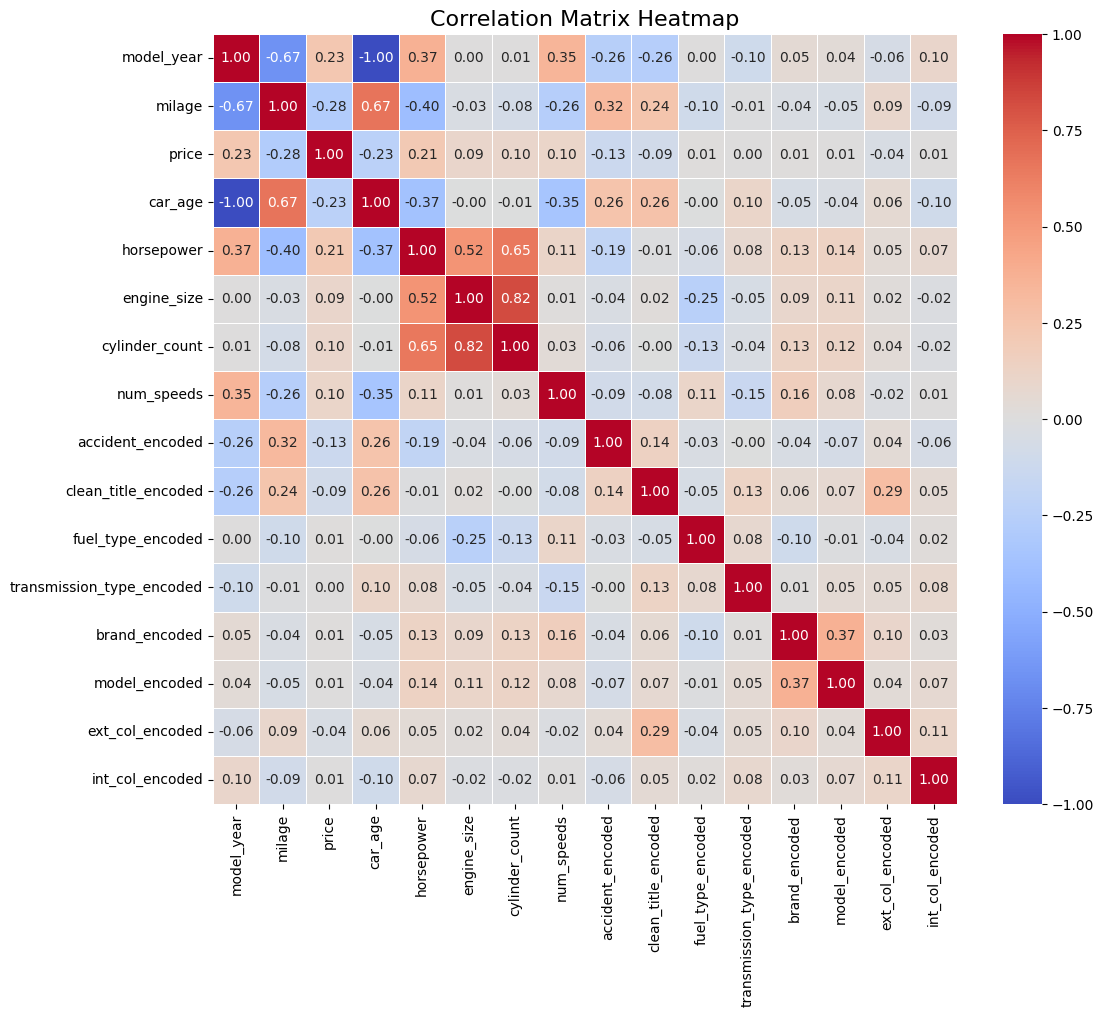

In [53]:
# Set the size of the plot
plt.figure(figsize=(12, 10))

# Generate a heatmap with correlation values
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap', size=16)
plt.show()

# Model Training

In [54]:
# Define target variable
y = train_data['price']

# Define features by dropping the target variable
X = train_data.drop('price', axis=1)


In [55]:
# Split into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

In [56]:
# Initialize the scaler
scaler = MinMaxScaler()

# Apply scaling only to the training and validation data for models that need it (like Linear Regression)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Apply scaling to the test data
X_test_scaled = scaler.transform(test_data)


## Model Selection and Training

### Linear Regression

In [57]:
# Initialize the model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)  # Use scaled data
y_pred_lr = lr.predict(X_val_scaled)
# Evaluate the model
rmse_lr = mean_squared_error(y_val, y_pred_lr, squared=False)
print(f'Linear Regression RMSE: {rmse_lr:.2f}')

Linear Regression RMSE: 74057.20


### Random Forest Regressor

In [58]:
# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=123)
rf.fit(X_train, y_train)  # No need for scaling
y_pred_rf = rf.predict(X_val)
# Evaluate the model
rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False)
print(f'Random Forest RMSE: {rmse_rf:.2f}')

Random Forest RMSE: 77652.59


### XGBoost Regressor

In [59]:
# Initialize the model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=123)
xgb_model.fit(X_train, y_train)  # No need for scaling
y_pred_xgb = xgb_model.predict(X_val)
# Evaluate the model
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)
print(f'XGBoost RMSE: {rmse_xgb:.2f}')

XGBoost RMSE: 73066.69


### LGBMRegressor

In [60]:
# Initialize the model
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=123)
lgb_model.fit(X_train, y_train)  # No need for scaling
y_pred_lgb = lgb_model.predict(X_val)
# Evaluate the model
rmse_lgb = mean_squared_error(y_val, y_pred_lgb, squared=False)
print(f'LGBM RMSE: {rmse_lgb:.2f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 15
[LightGBM] [Info] Start training from score 43972.269264
LGBM RMSE: 72181.72


### CatBoostRegressor

In [61]:
# Initialize the model
cat_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_state=123, verbose=False)
cat_model.fit(X_train, y_train)  # No need for scaling
y_pred_cat = cat_model.predict(X_val)
# Evaluate the model
rmse_cat = mean_squared_error(y_val, y_pred_cat, squared=False)
print(f'CatBoost RMSE: {rmse_cat:.2f}')

CatBoost RMSE: 72098.31


### Compare Model Performance

In [62]:
print(f'Linear Regression RMSE: {rmse_lr:.2f}')
print(f'Random Forest RMSE: {rmse_rf:.2f}')
print(f'XGBoost RMSE: {rmse_xgb:.2f}')
print(f'LGBM RMSE: {rmse_lgb:.2f}')
print(f'CatBoost RMSE: {rmse_cat:.2f}')

Linear Regression RMSE: 74057.20
Random Forest RMSE: 77652.59
XGBoost RMSE: 73066.69
LGBM RMSE: 72181.72
CatBoost RMSE: 72098.31


# Build Model with CatBoost

In [63]:
# Train the best model on the full training dataset 
best_model = cat_model 
best_model.fit(X, y)

# Make predictions on the test set
test_predictions = best_model.predict(test_data)

submission = pd.DataFrame({
    'id': df_sample_submission['id'],
    'price': test_predictions
})

# Print the head of the submission file
print(submission.head())

       id         price
0  188533  17285.214046
1  188534  77144.832188
2  188535  56005.063604
3  188536  30769.768503
4  188537  30154.376682


In [64]:
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully.")

Submission file created successfully.
